# Preface

In [1]:
%matplotlib inline
import getpass
import h5py
import itertools
import math
import numpy as np
import os
import pickle
import pyfits
import socket
import sys
import time

#require CosmoloPy
import cosmolopy.distance as cd
from scipy import integrate, interpolate

if getpass.getuser()=='ssaito':
    HOMEDIR = '/Users/ssaito/'
    #DIRNAME = HOMEDIR+'Dropbox/Work/Project/LyA_RT/sim_rt/illustris/test/catalog/'
elif getpass.getuser()=='shsaito':
    HOMEDIR = '/Users/shsaito/'
    #DIRNAME = '/Volumes/MyBookThunderboltDuo/CosmoTreasure/mock/cosmos/'
    
##CONSTANTS
Gnewton = 4.302E-9 #Mpc/Msun(km/s)**2
SQDEGtoSTR = math.pi**2./32400
Mpctocm = 3.0857E+24

## Plot
import matplotlib.pyplot as plt
from matplotlib import ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from ss_default_plot import *

## read subhalo catalog

In [2]:
#MDPL2 simulation
CP = {'omega_M_0':0.307115, 'omega_lambda_0':0.692885, 'omega_k_0':0.0, 'h':0.677700}
a_scale = 0.65650
z_red = 1./a_scale - 1.
KMpSECtoMPCpH = 1./a_scale/100./cd.e_z(z_red, **CP)
Lbox = 1000.

In [3]:
arr_subhalos = pyfits.open('/Volumes/MyBookThunderboltDuo/CosmoTreasure/sim/multidark/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.fits')[1].data

In [4]:
## check simulations
print 'total number of subhalos: {0}'.format(arr_subhalos.shape[0])
print '      number of hosts:    {0}'.format(np.where(arr_subhalos['upid']==-1)[0].shape[0])
print '      number of subhalos: {0}\n'.format(np.where(arr_subhalos['upid']!=-1)[0].shape[0])
print 'field includes:'
print arr_subhalos.names

total number of subhalos: 3834194
      number of hosts:    1214176
      number of subhalos: 2620018

field includes:
['id', 'upid', 'mvir', 'rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Rs_Klypin', 'M200b', 'Mpeak', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Vmax@Mpeak', 'vz_host', 'Mhost', 'Vpeak_host', 'Rsub', 'Zchar', 'Zform', 'Zacc', 'Zstarve']


In [44]:
select_host = np.logical_and(arr_subhalos['mvir']>=10.**13.5, arr_subhalos['upid']==-1)
print arr_subhalos[select_host]['rvir']/arr_subhalos[select_host]['Rs_Klypin']

[ 4.66879975  3.90148229  9.77986579 ...,  3.42083669  6.05934929
  6.14847983]


In [5]:
## read added values
arr_addvals = pyfits.open('/Volumes/MyBookThunderboltDuo/CosmoTreasure/sim/multidark/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits')[1].data

## add values for velocity profile

In [45]:
## sort the subhalo catalog
dtype_addvals = np.dtype([('id', int), ('upid', int), ('sid', int), 
                          ('x', float), ('y', float), ('z', float), 
                          ('vx', float), ('vy', float), ('vz', float), 
                          ('Xsub', float), ('Ysub', float), ('Zsub', float), ('Rsub', float), 
                          ('V_r', float), ('V_theta', float), ('V_phi', float), 
                          ('mvir_sub', float), ('mvir_host', float), ('rvir_host', float),
                          ('cvir_host', float), ('Vvir_host', float)])
arr_addvals = np.zeros(shape=arr_subhalos.shape[0], dtype=dtype_addvals)

for name in ['id','upid','x','y','z','vx','vy','vz']:
    arr_addvals[name][:] = arr_subhalos[name][:]
arr_addvals['mvir_sub'][:] = arr_subhalos['mvir'][:]
#as for now, insert all subhalo values for host properties
arr_addvals['mvir_host'][:] = arr_subhalos['mvir'][:]
arr_addvals['rvir_host'][:] = arr_subhalos['rvir'][:]/1000. #[Mpc/h]
arr_addvals['cvir_host'][:] = arr_subhalos['rvir'][:]/arr_subhalos['Rs_Klypin'][:]

#copy host id to sid to get a quick sort
arr_addvals['sid'][:] = arr_subhalos['upid'][:]
select_host = arr_addvals['sid']==-1
arr_addvals['sid'][select_host] = arr_addvals['id'][select_host]

#sort in terms of sid to collect a chunck of host-subhalos
arr_addvals.sort(order=('sid', 'upid'))
where_host = np.where(arr_addvals['upid']==-1)[0]

<Strong>Mapping from Cartesian to Spherical coordinate</Strong>

Positions:
\begin{eqnarray}
 X & = & r\sin\phi\cos\theta\\
 Y & = & r\sin\phi\sin\theta\\
 Z & = & r\cos\phi
\end{eqnarray}

Velocity: 
\begin{equation}
\vec{v} = \dot{r}\vec{e}_{r}+r\dot{\theta}\sin\phi\vec{e}_{\theta}+r\dot{\phi}\vec{e}_{\phi}
\end{equation}

where
\begin{eqnarray}
 \dot{r} & = & \frac{X v_{X}+Y v_{Y}+Z v_{Z}}{r}\\
 \dot{\theta} & = & \frac{v_{Y}X-v_{X}Y}{X^{2}+Y^{2}}\\
 \dot{\phi} & = & \frac{Z(Xv_{X}+Yv_{Y})-(X^{2}+Y^{2})v_{Z}}{r^{2}\sqrt{X^{2}+Y^{2}}}
\end{eqnarray}

In [24]:
def conv_Vcart_to_Vsphe(x, y, z, v_x, v_y, v_z):
    v_r = np.zeros(shape=(x.shape[0],), dtype=np.float)
    v_phi = np.zeros(shape=(x.shape[0],), dtype=np.float)
    v_theta = np.zeros(shape=(x.shape[0],), dtype=np.float)
    
    r = (x**2.+y**2.+z**2.)**0.5
    
    # v_r = rdot
    v_r = (x*v_x + y*v_y + z*v_z)/r
    
    #taking care of the X=Y=0 case
    select_xy0 = np.logical_and(x==0., y==0.)
    v_theta[select_xy0] = 0.
    if z[select_xy0]>0:
        v_phi[select_xy0] = (v_x[select_xy0]**2.+v_y[select_xy0]**2.)**0.5
    else:
        v_phi[select_xy0] = -(v_x[select_xy0]**2.+v_y[select_xy0]**2.)**0.5

    # v_theta = thetadot * r * sin(phi)
    v_theta[~select_xy0] = (v_y[~select_xy0]*x[~select_xy0] - v_x[~select_xy0]*y[~select_xy0])/(x[~select_xy0]**2.+y[~select_xy0]**2.)**0.5
    
    # v_phi = r * phidot
    v_phi[~select_xy0] = (z[~select_xy0]*(x[~select_xy0]*v_x[~select_xy0]+y[~select_xy0]*v_y[~select_xy0]) - v_z[~select_xy0]*(x[~select_xy0]**2.+y[~select_xy0]**2.))/r/(x[~select_xy0]**2.+y[~select_xy0]**2.)**0.5
    
    return v_r, v_theta, v_phi

In [46]:
%%time

for ihost in np.arange(where_host.shape[0]-1):
    indx_thishost = where_host[ihost]
    indx_nexthost = where_host[ihost+1]
    
    Xsub = arr_addvals['x'][indx_thishost+1:indx_nexthost] - arr_addvals['x'][indx_thishost]
    Ysub = arr_addvals['y'][indx_thishost+1:indx_nexthost] - arr_addvals['y'][indx_thishost]
    Zsub = arr_addvals['z'][indx_thishost+1:indx_nexthost] - arr_addvals['z'][indx_thishost]
    #taking care of periodic boundary condition
    where_Xsub_toolow = Xsub[:] < -10.
    Xsub[where_Xsub_toolow] += Lbox
    where_Xsub_toohigh = Xsub[:] > 10.
    Xsub[where_Xsub_toohigh] -= Lbox
    where_Ysub_toolow = Ysub[:] < -10.
    Ysub[where_Ysub_toolow] += Lbox
    where_Ysub_toohigh = Ysub[:] > 10.
    Ysub[where_Ysub_toohigh] -= Lbox
    where_Zsub_toolow = Zsub[:] < -10.
    Zsub[where_Zsub_toolow] += Lbox
    where_Zsub_toohigh = Zsub[:] > 10.
    Zsub[where_Zsub_toohigh] -= Lbox
    
    # host property
    arr_addvals['mvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['mvir_host'][indx_thishost]
    arr_addvals['rvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['rvir_host'][indx_thishost]
    arr_addvals['cvir_host'][indx_thishost+1:indx_nexthost] = arr_addvals['cvir_host'][indx_thishost]
    arr_addvals['Vvir_host'][indx_thishost+1:indx_nexthost] = np.sqrt(Gnewton*arr_addvals['mvir_host'][indx_thishost]/arr_addvals['rvir_host'][indx_thishost])
    
    
    # cartesian coordinate [Mpc/h]
    arr_addvals['Xsub'][indx_thishost+1:indx_nexthost] = Xsub
    arr_addvals['Ysub'][indx_thishost+1:indx_nexthost] = Ysub
    arr_addvals['Zsub'][indx_thishost+1:indx_nexthost] = Zsub
    arr_addvals['Rsub'][indx_thishost+1:indx_nexthost] = (Xsub**2.+Ysub**2.+Zsub**2.)**0.5
    
    # convert velocity [km/s] to [Mpc/h] 
    V_Xsub = (arr_addvals['vx'][indx_thishost+1:indx_nexthost] - arr_addvals['vx'][indx_thishost])*KMpSECtoMPCpH
    V_Ysub = (arr_addvals['vy'][indx_thishost+1:indx_nexthost] - arr_addvals['vy'][indx_thishost])*KMpSECtoMPCpH
    V_Zsub = (arr_addvals['vz'][indx_thishost+1:indx_nexthost] - arr_addvals['vz'][indx_thishost])*KMpSECtoMPCpH
    
    V_r, V_theta, V_phi = conv_Vcart_to_Vsphe(Xsub, Ysub, Zsub, V_Xsub, V_Ysub, V_Zsub)
    # now convert back to [km/s]
    arr_addvals['V_r'][indx_thishost+1:indx_nexthost] = V_r/KMpSECtoMPCpH
    arr_addvals['V_theta'][indx_thishost+1:indx_nexthost] = V_theta/KMpSECtoMPCpH
    arr_addvals['V_phi'][indx_thishost+1:indx_nexthost] = V_phi/KMpSECtoMPCpH

CPU times: user 7min 33s, sys: 1.81 s, total: 7min 35s
Wall time: 14min 21s


In [47]:
#save into fits file
Save_FitsColumns = pyfits.ColDefs([pyfits.Column(name='id', format='i8'),
                                   pyfits.Column(name='upid', format='i8'),
                                   pyfits.Column(name='sid', format='i8'),
                                   pyfits.Column(name='Xsub', format='f8'),
                                   pyfits.Column(name='Ysub', format='f8'),
                                   pyfits.Column(name='Zsub', format='f8'),
                                   pyfits.Column(name='Rsub', format='f8'),
                                   pyfits.Column(name='V_r', format='f8'),
                                   pyfits.Column(name='V_phi', format='f8'),
                                   pyfits.Column(name='V_theta', format='f8'), 
                                   pyfits.Column(name='mvir_sub', format='f8'),
                                   pyfits.Column(name='mvir_host', format='f8'),
                                   pyfits.Column(name='rvir_host', format='f8'),
                                   pyfits.Column(name='cvir_host', format='f8'),
                                   pyfits.Column(name='Vvir_host', format='f8')])

MYCOMMENTS = []
MYCOMMENTS.append("gerenrated by check_Jeans.ipynb")

tmptbhdu = pyfits.new_table(Save_FitsColumns, nrows=arr_addvals.shape[0])
for name in tmptbhdu.columns.names:
    tmptbhdu.data.field(name)[:] = arr_addvals[name][:]

tmppmhdu = pyfits.PrimaryHDU()
for i in xrange(len(MYCOMMENTS)):
    tmppmhdu.header.add_comment(MYCOMMENTS[i])

tmphdulist = pyfits.HDUList([tmppmhdu, tmptbhdu])
savefile = '/Volumes/MyBookThunderboltDuo/CosmoTreasure/sim/multidark/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits'
tmphdulist.writeto(savefile, clobber=True)
print 'catalog fits file is saved into', savefile

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


catalog fits file is saved into /Volumes/MyBookThunderboltDuo/CosmoTreasure/sim/multidark/MDPL2/Rockstar/halocatalog/hlist_0.65650.list.all.Vpeakcut160.0.hostsubs.Vprofile.fits


# Radial Profile

## First plot

Just for the first attempt, select host halos with Mhost > 10^13.5 Msun/h and subhalos hosted by them.

Warning: the subhalo catalog only includes Vpeak > 160 km/s

In [6]:
select = arr_subhalos['Mhost'] >= 10.**13.5
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
arr_addvals_tmp = arr_addvals[select]

In [7]:
print 'total number of subhalos: {0}'.format(arr_addvals_tmp.shape[0])
print '      number of hosts:    {0}'.format(np.where(arr_addvals_tmp['upid']==-1)[0].shape[0])
print '      number of subhalos: {0}\n'.format(np.where(arr_addvals_tmp['upid']!=-1)[0].shape[0])

total number of subhalos: 822351
      number of hosts:    75886
      number of subhalos: 746465



In [54]:
#radial binning setting
num_logRbins = 50
dlogR = (0.5+2.)/num_logRbins
bins_logR = np.array([-2. + dlogR*i for i in xrange(num_logRbins+1)])
meds_logR = np.array([(bins_logR[i]+bins_logR[i+1])/2. for i in xrange(num_logRbins)])
vol_logR = np.array([4.*np.pi*(10**bins_logR[i+1])**3./3. - 4.*np.pi*(10**bins_logR[i])**3./3. 
                     for i in xrange(num_logRbins)])

**radial profile of subhalos**

In [9]:
dndlogR = np.zeros(shape=(num_logRbins,3))
for ibin in xrange(num_logRbins):
    dndlogR[ibin,0] = meds_logR[ibin]
    
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logR[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logR[ibin+1])
    
    dndlogR[ibin,1] = float(arr_addvals_tmp[select].shape[0])/vol_logR[ibin]/dlogR/75886.
    dndlogR[ibin,2] = float(arr_addvals_tmp[select].shape[0])**0.5/vol_logR[ibin]/dlogR/75886.

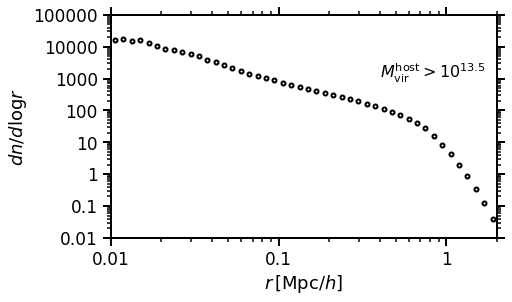

In [10]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
ax.set_yscale('log')
ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$dn/d\log r$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

#ax.plot(arr_zp06['OII_obs'][:], arr_zp06['OII_obs_itn'][:]*arr_zp06['ape_subaru']/arr_zp06['OII_obs'][:], 'rx', ms=3)
#ax.plot(arr_zp06['OII_obs'][:], arr_zp06['OII_obs_itn'][:]/arr_zp06['OII_obs'][:], 'bx', ms=3)


plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

**velocity profile**

In [11]:
stat_vel = np.zeros(shape=(num_logRbins,4))
for ibin in xrange(num_logRbins):
    stat_vel[ibin,0] = meds_logR[ibin]
    
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logR[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logR[ibin+1])
    
    stat_vel[ibin,1] = arr_addvals_tmp[select]['V_r'].mean()
    stat_vel[ibin,2] = arr_addvals_tmp[select]['V_r'].std()
    stat_vel[ibin,3] = (arr_addvals_tmp[select]['V_phi'].std()**2.+arr_addvals_tmp[select]['V_theta'].std()**2.)**0.5

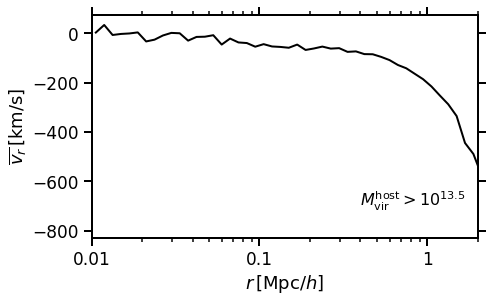

In [12]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\overline{v_{r}}\,[{\rm km/s}]$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, -700., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], stat_vel[:,1], 'k-', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

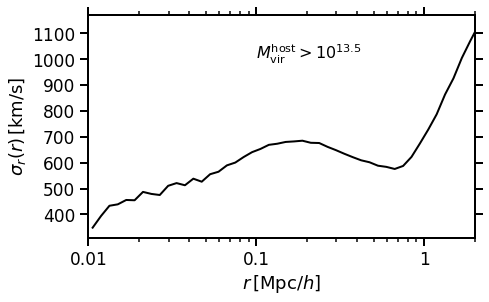

In [18]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\sigma_{r}(r)\,[{\rm km/s}]$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.1, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], stat_vel[:,2], 'k-', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

**anisotropy parameter**

\begin{equation}
  \beta = 1-\frac{\sigma_{\phi}^{2}+\sigma_{\theta}^{2}}{2\sigma_{r}^{2}}
\end{equation}

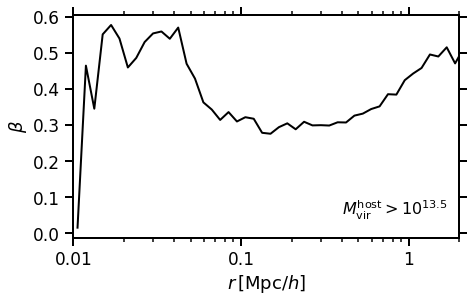

In [13]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$r\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\beta$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)


#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

#axleg = ax.legend(loc='upper right', numpoints=1, 
#                  ncol=1, fontsize=15, borderaxespad=0.2)
#axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()

## Jean's equation

See e.g. [Wojtak+(2005)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/0503391).

\begin{equation}
 \frac{d}{dr}\left\{\rho(r)\sigma_{r}^{2}(r)\right\}+\frac{2\beta}{r}\rho(r)\sigma_{r}^{2}(r)
 +\rho(r)\frac{d\Phi}{dr} = 0, 
\end{equation}
where $\rho(r)$ and $\sigma_{r}(r)$ are the density and radial velocity dipersion profile of the tracer population. 

In the NFW halo, the gravitational potential is simple given by
\begin{equation}
 \frac{\Phi(s)}{V^{2}_{\rm vir}} = -g(c)\frac{\ln(1+cs)}{c}, 
\end{equation}
where $s=r/r_{\rm vir}$, $g(c)=[\ln(1+c)-c/(1+c)]^{-1}$, and $V^{2}_{\rm vir}=GM_{\rm vir}/r_{\rm vir}$. 

In this case the Jean's equation is rewritten as
\begin{equation}
 \frac{d}{ds}\left\{\rho(s)\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}
 +\frac{2\beta}{s}\left\{\rho(s)\frac{\sigma_{r}^{2}(s)}{V_{\rm vir}^{2}}\right\}
 =-\rho(s)\frac{d\Phi}{ds}\frac{1}{V_{\rm vir}^{2}}.
\end{equation}

In [64]:
select = arr_subhalos['Mhost'] >= 10.**13.5
arr_tmp = arr_subhalos[select]

select = np.in1d(arr_addvals['id'], arr_tmp['id'])
select_sub = np.logical_and(select, arr_addvals['upid']!=-1)
arr_addvals_tmp = arr_addvals[select_sub]

In [53]:
arr_addvals_tmp[arr_addvals_tmp['upid']==-1]['cvir_host'].mean()

5.2562912405461422

In [59]:
def func_g(c):
    return 1./(np.log(1.+c)-c/(1.+c))

def func_minus_dPhids_perVvir2(s, c):
    return func_g(c)*(c*s/(1.+c*s)-np.log(1.+c*s))/s**2.

In [89]:
#radial binning setting
num_logsbins = 80
dlogs = (1.+2.)/num_logsbins
bins_logs = np.array([-2. + dlogs*i for i in xrange(num_logsbins+1)])
meds_logs = np.array([(bins_logs[i]+bins_logs[i+1])/2. for i in xrange(num_logsbins)])
vol_logs = np.array([4.*np.pi*(10**bins_logs[i+1])**3./3. - 4.*np.pi*(10**bins_logs[i])**3./3. 
                     for i in xrange(num_logsbins)])

In [65]:
#first rescale with rvir and Vvir
arr_addvals_tmp['Rsub'][:] = arr_addvals_tmp['Rsub'][:]/arr_addvals_tmp['rvir_host'][:]
arr_addvals_tmp['V_r'][:] = arr_addvals_tmp['V_r'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_phi'][:] = arr_addvals_tmp['V_phi'][:]/arr_addvals_tmp['Vvir_host'][:]
arr_addvals_tmp['V_theta'][:] = arr_addvals_tmp['V_theta'][:]/arr_addvals_tmp['Vvir_host'][:]

In [90]:
dndlogs = np.zeros(shape=(num_logsbins))
sig_vr = np.zeros(shape=(num_logsbins))
beta = np.zeros(shape=(num_logsbins))

for ibin in xrange(num_logsbins):
    select = np.logical_and(arr_addvals_tmp['Rsub']>=10.**bins_logs[ibin], 
                            arr_addvals_tmp['Rsub']< 10.**bins_logs[ibin+1])
    
    dndlogs[ibin] = float(arr_addvals_tmp[select].shape[0])/vol_logs[ibin]/dlogs/75886.
    sig_vr[ibin] = arr_addvals_tmp[select]['V_r'].std()
    beta[ibin] = 1.-(arr_addvals_tmp[select]['V_phi'].std()**2.+arr_addvals_tmp[select]['V_theta'].std()**2.)/2.*sig_vr[ibin]**2.

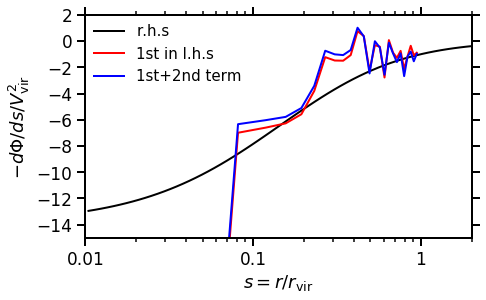

In [91]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.01,2.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(1.E-2,1.E5)
ax.set_ylim(-15.,2.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s=r/r_{\rm vir}$', fontsize=18)
ax.set_ylabel(r'$-d\Phi/ds/V_{\rm vir}^{2}$', fontsize=18)
#ax.set_title(r'3D-HST H$\alpha$ flux, $f_{\rm dust}=0.7$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 0.05, r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)


#ax.plot(10.**stat_vel[:,0], 1.-stat_vel[:,3]**2./2./stat_vel[:,2]**2., 'k-', lw=2)

c_mean = 5.2562912405461422
ax.plot(10.**meds_logs[:], func_minus_dPhids_perVvir2(10.**meds_logs[:], c_mean), 'k-', lw=2, label='r.h.s')

arr_1st_term = np.zeros(shape=(num_logsbins-2,2))
arr_2nd_term = np.zeros(shape=(num_logsbins-2))
for i in xrange(num_logsbins-2):
    arr_1st_term[i, 0] = meds_logs[i+1]
    arr_1st_term[i, 1] = (dndlogs[i+2]*sig_vr[i+2]**2.-dndlogs[i]*sig_vr[i]**2.)/(10.**meds_logs[i+2]-10.**meds_logs[i])/dndlogs[i+1]
    arr_2nd_term[i] = 2.*sig_vr[i+1]**2.*beta[i+1]/10.**meds_logs[i+1]
ax.plot(arr_1st_term[:,0], arr_1st_term[:,1], 'r-', lw=2, label='1st in l.h.s')
ax.plot(arr_1st_term[:,0], arr_1st_term[:,1]+arr_2nd_term[:], 'b-', lw=2, label='1st+2nd term')

#plt.errorbar(10.**dndlogR[:,0], dndlogR[:,1], yerr=dndlogR[:, 2],
#             fmt='ko', ms=4, mfc='white', mec='k', mew=2., zorder=1)

axleg = ax.legend(loc='upper left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

#plt.savefig(HOMEDIR+'Desktop/OIILuminosity_Yabe-vs-LAM.png')
plt.show()